# Imports

In [ ]:
import sys
sys.path.append('../..')

In [ ]:
# analysis
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.base import clone
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import h5py

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# local
import alignment.alignment_utils as utils
from alignment.AlignCCA import AlignCCA
from decomposition.DimRedReshape import DimRedReshape

%matplotlib inline

In [ ]:
def mean_stat(a, b, axis=0):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

# Data Loading

### Real data

In [17]:
paper_pt_dict = {'S14': 'S1', 'S26': 'S2', 'S33': 'S3', 'S22': 'S4', 'S23': 'S5', 'S39': 'S6', 'S58': 'S7', 'S62': 'S8'}

In [18]:
DATA_PATH = '../../data/'
# data_filename = DATA_PATH + 'pt_decoding_data_S62.pkl' # mean-subtracted
data_filename = DATA_PATH + 'pt_decoding_data_S62_zscore.pkl' # z-scored

In [19]:
all_pt_dict = utils.load_pkl(data_filename)
pt_names = list(all_pt_dict.keys())

In [20]:
pt_artic_maps = {}
for pt in pt_names:
    h5_fname = DATA_PATH + f'/articulator_maps/new/{pt}/{pt}_artic_elec_weights.h5'
    with h5py.File(h5_fname, 'r') as f:
        weights = f['weights'][()]
        weight_map = f['weight_map'][()]
    pt_artic_maps[pt] = {}
    pt_artic_maps[pt]['weights'] = weights
    pt_artic_maps[pt]['weight_map'] = weight_map

In [21]:
print(pt_names)
print(all_pt_dict[pt_names[0]].keys())
print([all_pt_dict[pt]['X1'].shape for pt in pt_names])

['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62']
dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])
[(144, 200, 111), (148, 200, 111), (151, 200, 63), (46, 200, 149), (151, 200, 74), (137, 200, 144), (141, 200, 171), (178, 200, 201)]


In [22]:
all_pt_chan_data = {}
for pt in pt_names:
    temp = {}
    temp['map'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_channelMap.mat'.format(pt))['chanMap']
    # if pt == 'S58':
    #     temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 2 # this is so weird
    # else:
    temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 1
    all_pt_chan_data[pt] = temp

## Phoneme label processing functions

In [23]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [24]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

## Data Processing

In [25]:
p_ind = 1

all_pt_traces = {}
all_pt_surr_traces = {}
all_pt_phon_labels = {}
all_pt_phon_seqs = {}
all_pt_phon_seqs_str = {}
all_pt_artic_labels = {}
all_pt_artic_seqs = {}
all_pt_artic_seqs_str = {}
all_pt_cv_labels = {}
for pt in pt_names:
    pt_trace = all_pt_dict[pt][f'X{p_ind}']  ### (trials, time, channels)

    pt_phon_labels = all_pt_dict[pt][f'y{p_ind}']
    pt_phon_seqs = all_pt_dict[pt]['y_full_phon']
    pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
    pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
    pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
    pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
    pt_cv_labels = labels2cv_seq(pt_phon_seqs)

    all_pt_traces[pt] = pt_trace
    all_pt_phon_labels[pt] = pt_phon_labels
    all_pt_phon_seqs[pt] = pt_phon_seqs
    all_pt_phon_seqs_str[pt] = pt_phon_seqs_str
    all_pt_artic_labels[pt] = pt_artic_labels
    all_pt_artic_seqs[pt] = pt_artic_seqs
    all_pt_artic_seqs_str[pt] = pt_artic_seqs_str
    all_pt_cv_labels[pt] = pt_cv_labels

In [26]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])

# Data Visualization

### Plotting utils

In [27]:
px_colors = [
             '#636EFA',
             '#FFA15A',
             '#EF553B',
             '#00CC96',
            #  '#72B7B2',
            #  '#990099',
            #  '#B6E880',

             
            #  '#FFA15A',
            #  '#19D3F3',
            #  '#FF6692',
            #  '#B6E880',
            #  '#FF97FF',
            #  '#FECB52',
            ]

In [28]:
# sns.set_theme(context='notebook', font='Arial', font_scale=1.15)
sns.set_theme(font='Arial', font_scale=1.2, style='white', palette=px_colors)
sns.set_style(rc={
    # 'axes.edgecolor': 'gray',
    'axes.linewidth': 0.5,
    'xtick.bottom': True,
    'ytick.left': True,
    })

In [29]:
from matplotlib.colors import LinearSegmentedColormap

parula_data = cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6), cbar_lower=None, cbar_upper=None, cmap=None):

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    if cmap is None:
        cmap = parula_map

    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data, cmap=parula_map)
    im.set_clim(clim[0], clim[1])
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    cbar.outline.set_visible(False)

    sns.despine(left=True, bottom=True)
    
    plt.show()

def chan_disp_seq(data, chan_map, t, t_ranges, labs, title, label, figsize=(3, 6), cbar_pos=[0.81, 0.56, 0.01, 0.3], sup_pos=0.95, cbar_lower=None, cbar_upper=None):
    f, tot_axs = plt.subplots(len(labs), len(t_ranges), figsize=(figsize[0]*len(t_ranges), figsize[1]*len(labs)))

    if len(labs) == 1:
        tot_axs = tot_axs[np.newaxis,:]

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    for j, lab in enumerate(labs):
        lab_data = data[j]
        axs = tot_axs[j]
        for i, t_range in enumerate(t_ranges):
            t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
            chan_data = np.array([lab_data[t_inds,:].mean(axis=0)[int(k)] if not np.isnan(k) else np.nan for k in (chan_map.flatten()-1)])
            chan_data = chan_data.reshape(chan_map.shape)
            im = axs[i].imshow(chan_data, cmap=parula_map)
            im.set_clim(clim[0], clim[1])
            if i==0:
                axs[i].set_ylabel(lab)
            if j==0:
                axs[i].set_title(f'{t_range[0]} -> {t_range[1]}s')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            

        # divider = make_axes_locatable(plt.gca())
        # cax = divider.append_axes('right', size='5%', pad=0.05)

        # cbar = plt.colorbar(im, cax=cax)
        
        # cbar.set_label(label)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes(cbar_pos)
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_label(label)

    # f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(title, y=sup_pos)
    plt.show()

In [31]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [32]:
def get_ci_data(ax):
    paths = [child for child in ax.get_children() if isinstance(child, mpl.collections.PolyCollection)]
    ci_data = []
    for path in paths:
        vertices = path.get_paths()[0].vertices  # Array of shape (n, 2)

        # ci y coords - contains lower bounds then upper bounds in 1D array
        ci_vals_tot = vertices[:-1, 1]

        ci_vals = np.zeros((200, 2))
        ci_vals[:,0] = ci_vals_tot[1:201]
        ci_vals[:,1] = ci_vals_tot[201:-1]
        ci_vals[:,1] = ci_vals[:,1][::-1] # reverse the order of the second half
        ci_data.append(ci_vals)
        
    return ci_data

### Reconstructions averaged across source patients

In [11]:
def vector_to_map(data, map):
    return np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (map.flatten()-1)]).reshape(map.shape)

def map_to_vector(map_data, map):
    return np.array([map_data[i // map.shape[1], i % map.shape[1]] if not np.isnan(i) else np.nan for i in (map.flatten()-1)])

In [12]:
from scipy.ndimage import gaussian_filter1d

def gfilt_with_nans(input, sigma, truncate=4.0):
    ### 1d filter in both dimensions subsequently to avoid nans ###

    # columns
    cols = [input[:,i].copy() for i in range(input.shape[1])]
    for i, col in enumerate(cols):
        # only consider non nan values
        nan_removed = col[~np.isnan(col)]
        if len(nan_removed) == 0:
            continue
        col[~np.isnan(col)] = gaussian_filter1d(nan_removed, sigma=sigma, truncate=truncate)
        cols[i] = col
    
    # merge back together
    col_filt = np.stack(cols, axis=1)

    # rows
    rows = [col_filt[i,:] for i in range(col_filt.shape[0])]
    for i, row in enumerate(rows):
        # only consider non nan values
        nan_removed = row[~np.isnan(row)]
        if len(nan_removed) == 0:
            continue
        row[~np.isnan(row)] = gaussian_filter1d(nan_removed, sigma=sigma, truncate=truncate)
        rows[i] = row

    # merge back together
    row_filt = np.stack(rows, axis=0)

    return row_filt
    

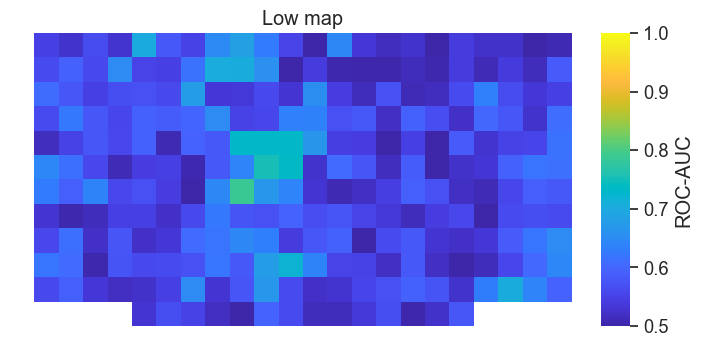

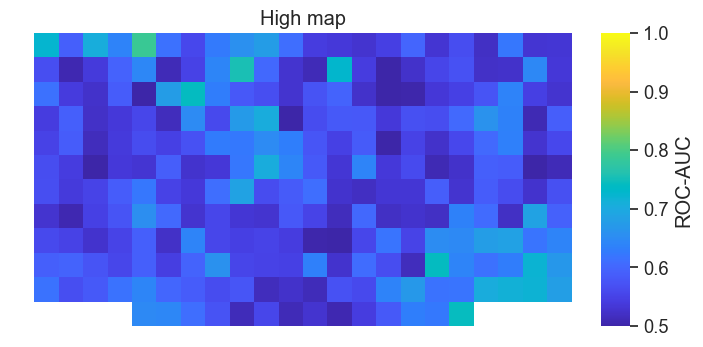

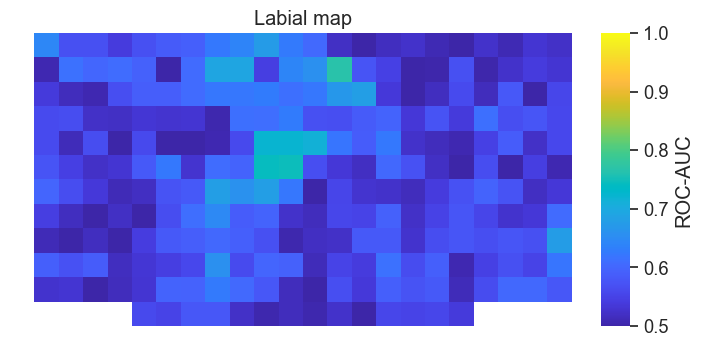

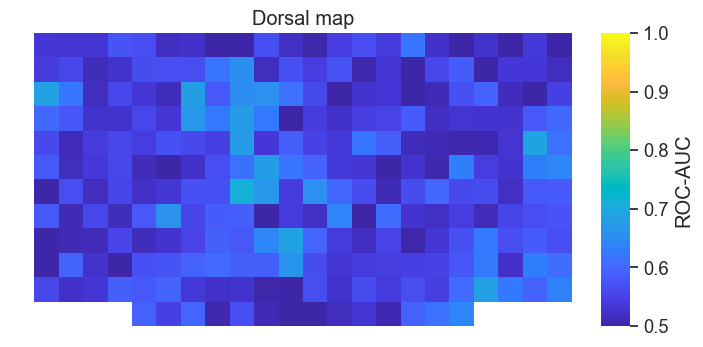

In [45]:
pt = 'S62'

pt_maps = pt_artic_maps[pt]
for i, artic in enumerate(artic_labels):
    chan_disp(pt_maps['weights'][i], pt_maps['weight_map'], str.capitalize(f'{artic} map'), 'ROC-AUC', figsize=(8, 6), cbar_lower=0.5, cbar_upper=1)
    # weights_2d = vector_to_map(pt_maps['weights'][i], pt_maps['weight_map'])
    # smoothed = gfilt_with_nans(weights_2d, 0.75, 2)
    # smoothed = gfilt_with_nans(pt_maps['weights'][i], 1)
    # chan_disp(map_to_vector(smoothed, pt_maps['weight_map']), pt_maps['weight_map'], str.capitalize(f'{artic} map'), 'ROC-AUC', figsize=(8, 6), cbar_lower=0.5, cbar_upper=1)

In [34]:
all_pt_elec_data = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
all_pt_good_chans = []
for i, (pt, d) in enumerate(zip(pt_names, all_pt_elec_data)):
    d[d == 0] = np.nan
    all_pt_good_chans.append(np.where(~np.isnan(d)[0,0,:])[0])
    all_pt_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)

Dictionary to hold data for all patients being aligned to a given patient (target patients for alignment are the keys to `alignDict_allPts` )

In [35]:
alignDict_allPts = {}
for recon_pt in tqdm(pt_names, desc='Patients'):
    recon_ind = pt_names.index(recon_pt)

    aligners = {}
    for i, pt in enumerate(pt_names):
        if i == recon_ind:
            continue
        aligners[pt] = AlignCCA()
                    
    pcas = {}
    to_align = {}
    for pt in pt_names:
        pcas[pt] = PCA(n_components=30)
        to_align[pt] = pcas[pt].fit_transform(all_pt_elec_data[pt_names.index(pt)].reshape(-1, all_pt_elec_data[pt_names.index(pt)].shape[-1]))
        to_align[pt] = to_align[pt].reshape(all_pt_elec_data[pt_names.index(pt)].shape[0], all_pt_elec_data[pt_names.index(pt)].shape[1], -1)

    aligned_data = {}
    aligned_data_null = {}
    aligned_data[recon_pt] = to_align[recon_pt]
    aligned_data_null[recon_pt] = to_align[recon_pt]
    for i, pt in enumerate(pt_names):
        if i == recon_ind:
            continue

        to_align_seqs = [all_pt_phon_seqs[recon_pt], all_pt_phon_seqs[pt]]
        aligners[pt].fit(to_align[recon_pt], to_align[pt], to_align_seqs[0], to_align_seqs[1])
        aligned_data[pt] = aligners[pt].transform(to_align[pt])

        aligned_data_null[pt] = to_align[pt]
        
    alignDict_allPts[recon_pt] = {
        'pcas': pcas,
        'aligners': aligners,
        'dr_data': to_align,
        'aligned_data': aligned_data,
        'aligned_data_null': aligned_data_null,
    }

Patients: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


##### S14 #####
Similarity between low map reconstruction: 0.5822850615582201
Similarity between low map null reconstruction: -0.03770712883354692


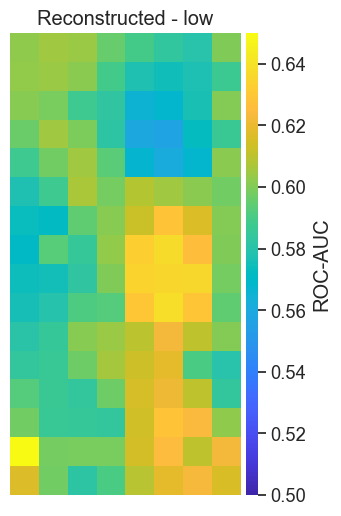

Similarity between high map reconstruction: -0.19678558998311868
Similarity between high map null reconstruction: 0.003623450428380288


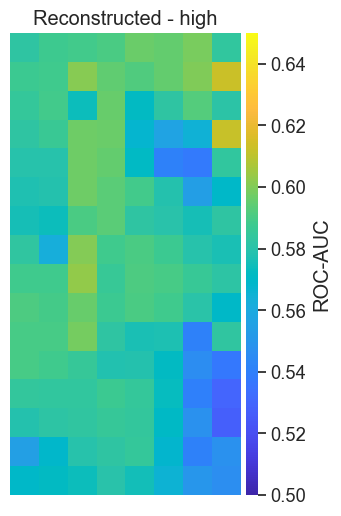

Similarity between labial map reconstruction: 0.6872406248552554
Similarity between labial map null reconstruction: -0.22912336857501053


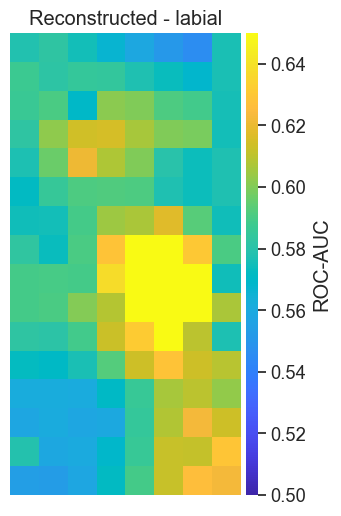

Similarity between dorsal map reconstruction: 0.3492879892533268
Similarity between dorsal map null reconstruction: -0.10191184333641509


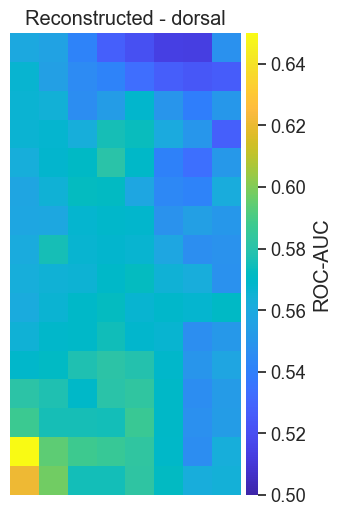

In [ ]:
artic_map_sims = {}
artic_map_sims_null = {}
for target_pt in ['S14']:
    print(f'##### {target_pt} #####')

    target_maps = pt_artic_maps[target_pt]['weights']
    target_pt_ind = pt_names.index(target_pt)
    target_dr = alignDict_allPts[target_pt]['pcas'][target_pt]
    target_chan_map = pt_artic_maps[target_pt]['weight_map']
    artic_map_sims[target_pt] = {}
    artic_map_sims_null[target_pt] = {}

    pt_names_artic_recon = [target_pt] + [pt for pt in pt_names if pt != target_pt]
    # pt_names_artic_recon = [target_pt] + ['S33']

    sim_values = []
    sim_values_null = []
    artic_recons = np.zeros((target_maps.shape[0], len(pt_names_artic_recon[1:]), all_pt_elec_data[pt_names.index(target_pt)].shape[-1]))
    artic_nulls = np.zeros((target_maps.shape[0], len(pt_names_artic_recon[1:]), all_pt_elec_data[pt_names.index(target_pt)].shape[-1]))
    for i_artic, lab in enumerate(artic_labels):
        map_target = target_maps[i_artic]

        for i_pt, input_pt in enumerate(pt_names_artic_recon[1:]):
            map_input = pt_artic_maps[input_pt]['weights'][i_artic]
            input_pt_ind = pt_names.index(input_pt)

            input_dr = alignDict_allPts[target_pt]['pcas'][input_pt]
            align = alignDict_allPts[target_pt]['aligners'][input_pt]

            map_flat = map_input.flatten()[~np.isnan(map_input.flatten())]
            map_flat = map_flat[None, :] # expand dims for compatibility with transformations below

            map_target_flat = map_target.flatten()[~np.isnan(map_target.flatten())]

            map_dr = (map_flat - np.mean(map_flat)) @ input_dr.components_.T

            M_a = align.M_a
            M_b = align.M_b
            map_align = map_dr @ M_b @ np.linalg.pinv(M_a)

            map_recon = map_align @ target_dr.components_
            map_null = map_dr @ target_dr.components_

            artic_recons[i_artic, i_pt, :] = map_recon.squeeze()
            artic_nulls[i_artic, i_pt, :] = map_null.squeeze()

        avg_recon_map = np.mean(artic_recons[i_artic], axis=0)
        avg_null_map = np.mean(artic_nulls[i_artic], axis=0)

        avg_recon_map_norm = avg_recon_map + np.mean(map_flat)
        sim = stats.pearsonr(avg_recon_map_norm, map_target_flat)[0]
        sim_values.append(sim)
        print(f'Similarity between {lab} map reconstruction: {sim}')

        avg_null_map_norm = avg_null_map + np.mean(map_flat)
        sim_null = stats.pearsonr(avg_null_map_norm, map_target_flat)[0]
        sim_values_null.append(sim_null)
        print(f'Similarity between {lab} map null reconstruction: {sim_null}')

        chan_disp(avg_recon_map_norm, target_chan_map,
                      f'Reconstructed - {lab}', 'ROC-AUC', figsize=(8, 6),
                      cbar_lower=0.5, 
                      cbar_upper=0.65
                      )       

        artic_map_sims[target_pt][lab] = sim
        artic_map_sims_null[target_pt][lab] = sim_null

In [47]:
artic_sim_S1_df = pd.DataFrame(artic_map_sims).T
artic_sim_S1_df['Patient'] = artic_sim_S1_df.index
artic_sim_S1_df = artic_sim_S1_df.reset_index(drop=True)
artic_sim_S1_df = pd.melt(artic_sim_S1_df, id_vars=['Patient'], var_name='Articulator', value_name='Cosine Similarity')
artic_sim_S1_df = artic_sim_S1_df.loc[[3, 1, 2, 0]]

artic_sim_null_S1_df = pd.DataFrame(artic_map_sims_null).T
artic_sim_null_S1_df['Patient'] = artic_sim_null_S1_df.index
artic_sim_null_S1_df = artic_sim_null_S1_df.reset_index(drop=True)
artic_sim_null_S1_df = pd.melt(artic_sim_null_S1_df, id_vars=['Patient'], var_name='Articulator', value_name='Cosine Similarity')
artic_sim_null_S1_df = artic_sim_null_S1_df.loc[[3, 1, 2, 0]]

artic_sim_S1_df['Type'] = 'Aligned'
artic_sim_null_S1_df['Type'] = 'Unaligned'
artic_sim_full_S1_df = pd.concat([artic_sim_S1_df, artic_sim_null_S1_df])
artic_sim_full_S1_df['Articulator'] = artic_sim_full_S1_df['Articulator'].str.capitalize()
artic_sim_full_S1_df = artic_sim_full_S1_df[['Patient', 'Articulator', 'Type', 'Cosine Similarity']]
artic_sim_full_S1_df



,Patient,Articulator,Type,Cosine Similarity
3,S14,Low,Aligned,0.582285
1,S14,High,Aligned,-0.196786
2,S14,Labial,Aligned,0.687241
0,S14,Dorsal,Aligned,0.349288
3,S14,Low,Unaligned,-0.037707
1,S14,High,Unaligned,0.003623
2,S14,Labial,Unaligned,-0.229123
0,S14,Dorsal,Unaligned,-0.101912


In [ ]:
fig = px.histogram(artic_sim_full_S1_df, x='Articulator', y="Cosine Similarity", color='Type', barmode='group', width=800, height=600, color_discrete_sequence=[px_colors[0], '#7F7F7F'])

fig.add_hline(y=0, line_dash='dash', line_color='grey')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    title_text='Similarity of S1 reconstructed articulator maps',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='Articulator Type',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)
fig.update_yaxes(
    title='Pearson <i>r</i>',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.25, 0.65],
)

fig.show()